# Imports

In [1]:
import torch
from torch import optim, nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
torch.manual_seed(42)

import sys
sys.path.append('..')
from unet import Unet
from unet import CustomDataset

# Params & Dataset

In [2]:
IMG_SHAPE = (64,64)
X_PATH = "../data/train/"
Y_PATH = "../data/train_masks/"
X_TEST_PATH = "../data/manual_test/"
Y_TEST_PATH = "../data/manual_test_masks/"
MODEL_SAVE_PATH = "../weights/unet.pth"
FEATS = [32]

LEARNING_RATE = 3e-3
BATCH_SIZE = 32
EPOCHS = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.Resize(IMG_SHAPE),
    transforms.ToTensor()
    ])
train_dataset = CustomDataset(X_path=X_PATH, Y_path=Y_PATH, transform=transform)
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

tensor([[[0.9608, 0.9569, 0.9569,  ..., 0.9176, 0.9176, 0.9137],
         [0.9569, 0.9569, 0.9529,  ..., 0.9176, 0.9137, 0.9137],
         [0.9569, 0.9490, 0.9490,  ..., 0.9137, 0.9137, 0.9137],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.8000, 0.8118, 0.8235],
         [0.7804, 0.7804, 0.7725,  ..., 0.8314, 0.8275, 0.8431],
         [0.8275, 0.8275, 0.8235,  ..., 0.8588, 0.8549, 0.8667]],

        [[0.9529, 0.9529, 0.9529,  ..., 0.9020, 0.9020, 0.8980],
         [0.9529, 0.9490, 0.9490,  ..., 0.9020, 0.8980, 0.8980],
         [0.9451, 0.9451, 0.9451,  ..., 0.8980, 0.8980, 0.8980],
         ...,
         [0.7608, 0.7608, 0.7608,  ..., 0.7961, 0.8078, 0.8157],
         [0.7765, 0.7765, 0.7686,  ..., 0.8157, 0.8157, 0.8275],
         [0.8235, 0.8235, 0.8196,  ..., 0.8392, 0.8392, 0.8510]],

        [[0.9725, 0.9725, 0.9725,  ..., 0.9059, 0.9059, 0.9020],
         [0.9725, 0.9686, 0.9686,  ..., 0.9059, 0.9020, 0.9020],
         [0.9686, 0.9647, 0.9647,  ..., 0.9020, 0.9020, 0.

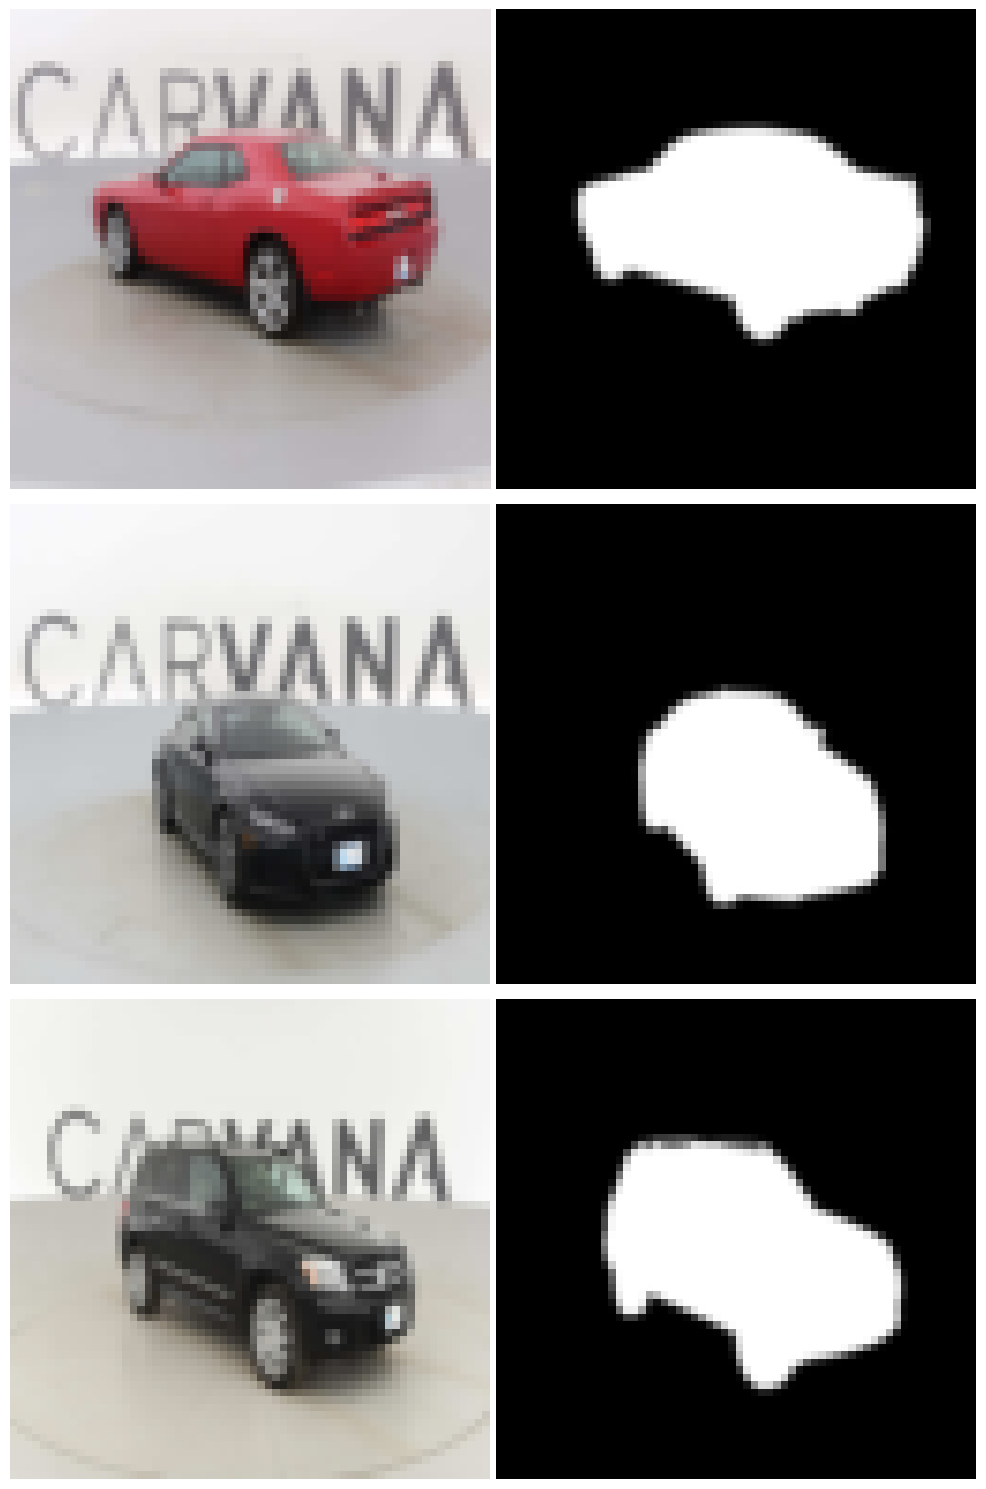

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 2, figsize=(10, 15)) # 3 rows, 2 columns

for i in range(3):
    image, mask = train_dataset[i]
    print(image.float().to(device))

    image = np.transpose(image, (1, 2, 0))
    mask = np.transpose(mask, (1, 2, 0))

    axs[i, 0].imshow(image)
    axs[i, 1].imshow(mask, cmap='gray')
    
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Model

In [4]:
model = Unet(in_channels=3, out_channels=1, feats=FEATS).to(device=device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# Lets Train

In [5]:
for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    for idx, img_mask in enumerate(tqdm(train_dataloader)):
        img, mask = img_mask
        img = img.float().to(device)
        mask = mask.float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        loss = criterion(y_pred, mask)
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()
    train_loss = train_running_loss / (idx+1)

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader)):
            img, mask = img_mask
            mask = (mask>0.5).float().to(device)
            img = img.float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)

            val_running_loss += loss.item()
        val_loss = val_running_loss / (idx+1)
    
    print(f"Ep:{epoch+1} Train_loss:{train_loss:.4f} Val_loss:{val_loss:.4f}")

 50%|█████     | 1/2 [03:34<03:34, 214.55s/it]

Ep:1 Train_loss:0.1236 Val_loss:0.4376


100%|██████████| 2/2 [07:10<00:00, 215.18s/it]

Ep:2 Train_loss:0.0415 Val_loss:0.0394


In [6]:
torch.save(model.state_dict(), MODEL_SAVE_PATH)

# Inference

In [7]:
model = Unet(in_channels=3, out_channels=1, feats=FEATS).to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=torch.device(device)))
test_dataset = CustomDataset(X_path=X_TEST_PATH, Y_path=Y_TEST_PATH, transform=transform)
images = []
orig_masks = []
pred_masks = []

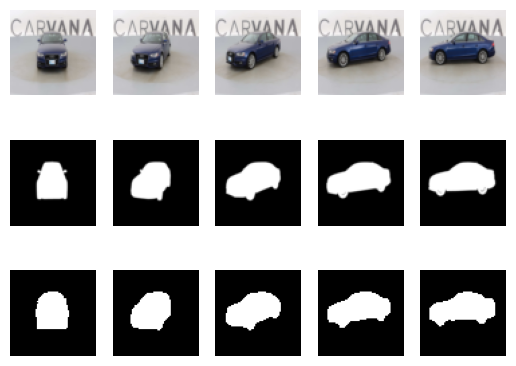

In [8]:
for img, orig_mask in test_dataset:
    img = img.float().to(device)
    img = img.unsqueeze(0)

    pred_mask = model(img)

    img = img.squeeze(0).cpu().detach()
    img = img.permute(1, 2, 0)

    pred_mask = pred_mask.squeeze(0).cpu().detach()
    pred_mask = pred_mask.permute(1, 2, 0)
    pred_mask[pred_mask < 0]=0
    pred_mask[pred_mask > 0]=1

    orig_mask = orig_mask.cpu().detach()
    orig_mask = orig_mask.permute(1, 2, 0)

    images.append(img)
    orig_masks.append(orig_mask)
    pred_masks.append(pred_mask)

images.extend(orig_masks)
images.extend(pred_masks)
fig = plt.figure()
for i in range(1, 3*len(test_dataset)+1):
    fig.add_subplot(3, len(test_dataset), i)
    plt.imshow(images[i-1], cmap="gray")
    plt.axis('off')
plt.show()